# Sevendi Eldrige Rifki Poluan🔥🔥🔥
### Descriptions: Time series prediction

In [3]:
# working environment
!nvidia-smi

Mon Apr 10 17:32:51 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:65:00.0 Off |                  N/A |
|  0%   43C    P8               38W / 390W|    225MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## <font color='red'>Import the necessary libraries</font>

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os  
import time 
import datetime

2023-04-10 17:32:54.282631: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-10 17:32:54.320216: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <font color='red'>For this experiment, I will be conducting basic time series forecasting on EUR_USD data from the forex market, covering the period from 2005 to 2020. The dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/imetomi/eur-usd-forex-pair-historical-data-2002-2019?resource=download), where you can also access and download the dataset.</font>

In [2]:
!ls

FOREX_EUR_USD_prediction.ipynb	archive.zip	 eurusd_minute.csv
README.md			eurusd_hour.csv  eurusd_news.csv


In [4]:
!unzip -o archive.zip

Archive:  archive.zip
  inflating: eurusd_hour.csv         
  inflating: eurusd_minute.csv       
  inflating: eurusd_news.csv         


In [5]:
!ls

FOREX_EUR_USD_prediction.ipynb	eurusd_hour.csv    eurusd_news.csv
archive.zip			eurusd_minute.csv


## <font color='red'>Let's load the dataset for one-minute data prediction.</font>

In [5]:
datasets_hour = pd.read_csv("eurusd_hour.csv")

In [6]:
datasets_hour.head()

,Date,Time,BO,BH,BL,BC,BCh,AO,AH,AL,AC,ACh
0,2005-05-02,00:00,1.2852,1.2852,1.2840,1.2844,-0.0008,1.2854,1.2854,1.2842,1.2846,-0.0008
1,2005-05-02,01:00,1.2844,1.2848,1.2839,1.2842,-0.0002,1.2846,1.2850,1.2841,1.2844,-0.0002
2,2005-05-02,02:00,1.2843,1.2854,1.2841,1.2851,0.0008,1.2845,1.2856,1.2843,1.2853,0.0008
3,2005-05-02,03:00,1.2851,1.2859,1.2850,1.2851,0.0000,1.2853,1.2861,1.2852,1.2853,0.0000
4,2005-05-02,04:00,1.2852,1.2859,1.2849,1.2855,0.0003,1.2854,1.2861,1.2851,1.2857,0.0003


In [7]:
datasets_hour.shape

(93084, 12)

In [8]:
max(datasets_hour.Date), min(datasets_hour.Date)

('2020-04-29', '2005-05-02')

<Axes: >

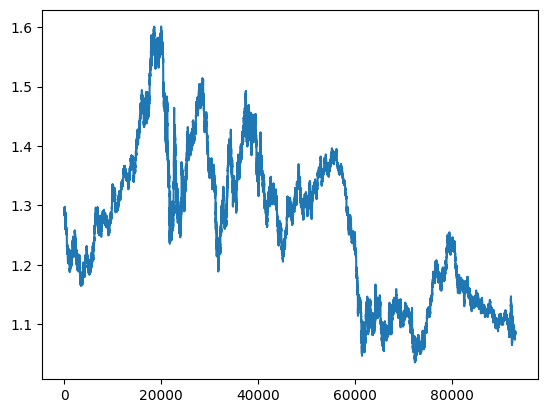

In [9]:
datasets_hour.BO.plot()

## <font color='red'>Given that time series data, such as forex market data, can exhibit seasonal patterns, I have decided to incorporate both date and hour information as training data. To encode these time units in a cyclical manner, I will use Periodicity encoding techniques, such as sine and cosine functions, to represent the cyclical patterns of date and hour information in a continuous and periodic manner.</font>

    Periodicity encoding is a technique used in machine learning to represent time units, such as hours, days, months, or seasons, as periodic features using trigonometric functions, typically sine and cosine. This encoding allows the model to capture periodic patterns in the data more accurately, as it accounts for the cyclical nature of time units.

    The basic idea behind periodicity encoding is to map time units onto a continuous scale that represents their cyclical patterns. For example, in a 24-hour time format, the hours repeat in a cyclical pattern from 0 to 23. By using sine and cosine functions, which have periodic properties with values ranging from -1 to 1, we can map the time units onto this continuous scale in a way that captures their cyclical patterns.

    By encoding time units as periodic features, the model can learn to capture the cyclical patterns in the data more effectively. For example, in time series forecasting tasks, where the data exhibits periodic patterns such as daily or seasonal trends, periodicity encoding can help the model better understand and utilize these patterns in its predictions.

In [10]:
datasets_hour["month_sin"] = datasets_hour.Date.apply(lambda x: np.sin(2 * np.pi * int(x.split("-")[1]) / 12))
datasets_hour["month_cos"] = datasets_hour.Date.apply(lambda x: np.cos(2 * np.pi * int(x.split("-")[1]) / 12))

datasets_hour["date_sin"] = datasets_hour.Date.apply(lambda x: np.sin(2 * np.pi * int(x.split("-")[2]) / 31))
datasets_hour["date_cos"] = datasets_hour.Date.apply(lambda x: np.cos(2 * np.pi * int(x.split("-")[2]) / 31))

datasets_hour["hour_sin"] = datasets_hour.Time.apply(lambda x: np.sin(2 * np.pi * int(x.split(":")[0]) / 12))
datasets_hour["hour_cos"] = datasets_hour.Time.apply(lambda x: np.cos(2 * np.pi * int(x.split(":")[0]) / 12)) 

In [11]:
datasets_hour.head()

,Date,Time,BO,BH,BL,BC,BCh,AO,AH,AL,AC,ACh,month_sin,month_cos,date_sin,date_cos,hour_sin,hour_cos
0,2005-05-02,00:00,1.2852,1.2852,1.2840,1.2844,-0.0008,1.2854,1.2854,1.2842,1.2846,-0.0008,0.5,-0.866025,0.394356,0.918958,0.000000,1.000000e+00
1,2005-05-02,01:00,1.2844,1.2848,1.2839,1.2842,-0.0002,1.2846,1.2850,1.2841,1.2844,-0.0002,0.5,-0.866025,0.394356,0.918958,0.500000,8.660254e-01
2,2005-05-02,02:00,1.2843,1.2854,1.2841,1.2851,0.0008,1.2845,1.2856,1.2843,1.2853,0.0008,0.5,-0.866025,0.394356,0.918958,0.866025,5.000000e-01
3,2005-05-02,03:00,1.2851,1.2859,1.2850,1.2851,0.0000,1.2853,1.2861,1.2852,1.2853,0.0000,0.5,-0.866025,0.394356,0.918958,1.000000,6.123234e-17
4,2005-05-02,04:00,1.2852,1.2859,1.2849,1.2855,0.0003,1.2854,1.2861,1.2851,1.2857,0.0003,0.5,-0.866025,0.394356,0.918958,0.866025,-5.000000e-01


## <font color='red'>I will exclude the "Date" and "Time" columns from the dataset.</font>

In [12]:
datasets = datasets_hour[datasets_hour.columns[2:]]

In [13]:
datasets.head()

,BO,BH,BL,BC,BCh,AO,AH,AL,AC,ACh,month_sin,month_cos,date_sin,date_cos,hour_sin,hour_cos
0,1.2852,1.2852,1.2840,1.2844,-0.0008,1.2854,1.2854,1.2842,1.2846,-0.0008,0.5,-0.866025,0.394356,0.918958,0.000000,1.000000e+00
1,1.2844,1.2848,1.2839,1.2842,-0.0002,1.2846,1.2850,1.2841,1.2844,-0.0002,0.5,-0.866025,0.394356,0.918958,0.500000,8.660254e-01
2,1.2843,1.2854,1.2841,1.2851,0.0008,1.2845,1.2856,1.2843,1.2853,0.0008,0.5,-0.866025,0.394356,0.918958,0.866025,5.000000e-01
3,1.2851,1.2859,1.2850,1.2851,0.0000,1.2853,1.2861,1.2852,1.2853,0.0000,0.5,-0.866025,0.394356,0.918958,1.000000,6.123234e-17
4,1.2852,1.2859,1.2849,1.2855,0.0003,1.2854,1.2861,1.2851,1.2857,0.0003,0.5,-0.866025,0.394356,0.918958,0.866025,-5.000000e-01


## <font color='red'>Next, we will define the sequence and label for the prediction.</font>

    In this approach, I will use a shortcut to map the dataset into a sequence array of IDs. This helps to minimize the time and memory required for formulating the dataset into a sequence from scratch, making the process more efficient.

In [14]:
SEQ = 7 # total sequence
TARGET_NEXT = 1 # next 1/2/3 hour(s)
dt_length = datasets.shape[0] # total datasets
TOTAL_SEQUENCE = dt_length // (SEQ + TARGET_NEXT)
CHANNEL = datasets.shape[1]

In [15]:
IDS = np.expand_dims(np.arange(0, TOTAL_SEQUENCE, SEQ), axis=1) + np.arange(0, SEQ + TARGET_NEXT)
IDS

array([[    0,     1,     2, ...,     5,     6,     7],
       [    7,     8,     9, ...,    12,    13,    14],
       [   14,    15,    16, ...,    19,    20,    21],
       ...,
       [11620, 11621, 11622, ..., 11625, 11626, 11627],
       [11627, 11628, 11629, ..., 11632, 11633, 11634],
       [11634, 11635, 11636, ..., 11639, 11640, 11641]])

In [16]:
INP_IDS = IDS[:, :-TARGET_NEXT]
INP_IDS

array([[    0,     1,     2, ...,     4,     5,     6],
       [    7,     8,     9, ...,    11,    12,    13],
       [   14,    15,    16, ...,    18,    19,    20],
       ...,
       [11620, 11621, 11622, ..., 11624, 11625, 11626],
       [11627, 11628, 11629, ..., 11631, 11632, 11633],
       [11634, 11635, 11636, ..., 11638, 11639, 11640]])

In [17]:
LBL_IDS = IDS[:, -1:]
LBL_IDS

array([[    7],
       [   14],
       [   21],
       ...,
       [11627],
       [11634],
       [11641]])

## <font color='red'>Now we can use the ID sequence to map the dataset, separating it into input and label components.</font>
    
       In this scenario, I will attempt to predict two prices: the bid close price and ask close price. I will make the assumption that the predicted prices will be in the vicinity of the bid and ask close prices.

In [18]:
X = np.array(datasets)[INP_IDS]
Y = (np.array(datasets[["AC", "BC"]])[LBL_IDS]) # predict labels
Y = Y.reshape([Y.shape[0], Y.shape[-1]])

In [19]:
X.shape, Y.shape

((1663, 7, 16), (1663, 2))

In [20]:
Y.reshape([Y.shape[0], Y.shape[-1]]).shape

(1663, 2)

## <font color='red'>Now we can proceed to split our dataset into training and testing subsets.</font>

    Since this is time series data, we won't shuffle the data during the splitting process. Instead, we'll split the data based on a given percentage, taking data from the last point in the dataset up to the specified percentage.

In [21]:
PERCENTAGE = 0.2

In [22]:
x_train, y_train = X[:int(X.shape[0] * PERCENTAGE)], Y[:int(X.shape[0] * PERCENTAGE)]
x_test, y_test = X[-int(X.shape[0] * PERCENTAGE):], Y[-int(X.shape[0] * PERCENTAGE):]

In [23]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) 

2023-04-10 17:33:12.508478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22018 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


## <font color='red'>I will now proceed to construct our model for training.</font>

In [24]:
def create_model():
    tf.keras.mixed_precision.set_global_policy("mixed_float16")
    
    inputs = tf.keras.layers.Input(shape=(SEQ, CHANNEL))
    x = tf.keras.layers.Conv1D(256, 3, activation='relu')(inputs)
    x = tf.keras.layers.Conv1D(256, 3, activation='relu')(x) 
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer="l2")(x)
    outputs = tf.keras.layers.Dense(Y.shape[1], activation="linear")(x) 
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss="mse", 
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["mse"])
    
    return model

In [25]:
model = create_model()
model.summary()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 16)]           0         
                                                                 
 conv1d (Conv1D)             (None, 5, 256)            12544     
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 256)            196864    
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)    

## <font color='red'>We will define callbacks for updating the learning rate, implementing early stopping if the model does not show improvement, and saving the model whenever there is a decrease in the training loss.</font>

In [26]:
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, factor, patience, min_lr):
        super(CustomLearningRateScheduler, self).__init__()
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.wait = 0
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        
        # print('\rlr_logs: ', logs, '\r')
        print("\rwait: ", self.wait, "\r")
        print("\rCurrent lr:", tf.keras.backend.get_value(self.model.optimizer.lr), "\r")
        
        current_val_loss = logs['val_loss'] 
        
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1
            print("\rself.wait >= self.patience:", self.wait >= self.patience, "\r")
            if self.wait >= self.patience:
                old_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
                new_lr = old_lr * self.factor
                
                print("\rnew_lr >= self.min_lr:", new_lr >= self.min_lr, "\r")
                if new_lr >= self.min_lr:
                    print(f'\rEpoch {epoch+1}: Learning rate reduced to {new_lr} \r')
                    tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) 
                else:
                    print(f'\rEpoch {epoch+1}: Minimum learning rate reached\r')
                self.wait = 0
                
lr_callback = CustomLearningRateScheduler(factor=0.1, 
                                          patience=5,
                                          min_lr=1e-7) 

In [27]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                               patience=4, # Number of epochs with no improvement after which training will be stopped.
                                               start_from_epoch=1,
                                               mode="min") # training will stop when the quantity monitored has stopped decreasing

In [28]:
class ModelCheckpointCustom(tf.keras.callbacks.Callback):
    
    def __init__(self, model_path, save_best_only=False):
        super(ModelCheckpointCustom, self).__init__()
         
        self.model_path = model_path
        self.save_best_only = save_best_only
        self.best_val_loss = float('inf') 

    def on_epoch_end(self, epoch, logs=None):
        
        print('\rlogs: ', logs, '\r')
        
        current_val_loss = 0 if logs['val_loss'] is None else logs['val_loss']
        
        print('\rcurrent_val_loss: ', current_val_loss, '\r')
        print('\rsave_best_only: ', self.save_best_only, '\r')
        print('\rbest_val_loss: ', self.best_val_loss, '\r')
        print('\rcurrent_val_loss < best_val_loss: ', current_val_loss < self.best_val_loss, '\r') 
        
        if self.save_best_only and current_val_loss < self.best_val_loss:
            print('\rSaving weights at (save_best_only=True): ', self.model_path, '\r')
            self.best_val_loss = current_val_loss 
            self.model.save_weights(self.model_path)
            print("\rModel has been saved!")
        else:
            print('\rSaving weights at (save_best_only=False): ', self.model_path, '\r')
            self.model.save_weights(self.model_path) 
            print("\rModel has been saved!")

save_callbacks = ModelCheckpointCustom(model_path='checkpoint/save-model/', save_best_only=True)

## <font color='red'>Now, it is time to commence the training process of our model.</font>

In [29]:
BATCH_SIZE = 100

train = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()
test = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [30]:
for x in train:
    print(x[0].shape, x[1].shape)
    break

(100, 7, 16) (100, 2)


2023-04-10 17:33:16.839279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [332,2]
	 [[{{node Placeholder/_1}}]]
2023-04-10 17:33:16.853502: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [31]:
history = model.fit(train, epochs=100, validation_data=test, validation_steps=len(test) * 0.25, callbacks=[save_callbacks, es_callback, lr_callback])

Epoch 1/100


2023-04-10 17:33:20.294874: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-10 17:33:21.337446: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fb67f11fdc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-10 17:33:21.337480: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-04-10 17:33:21.341291: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-10 17:33:21.462297: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


logs:  {'loss': 2.4645824432373047, 'mse': 0.7908599376678467, 'val_loss': 1.7107632160186768, 'val_mse': 0.1052289754152298} 
current_val_loss:  1.7107632160186768 
save_best_only:  True 
best_val_loss:  inf 
current_val_loss < best_val_loss:  True 
Saving weights at (save_best_only=True):  checkpoint/save-model/ 


2023-04-10 17:33:21.674334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [332,2]
	 [[{{node Placeholder/_1}}]]


Model has been saved!
wait:  0 
Current lr: 0.001 
4/4 [==============================] - 4s 140ms/step - loss: 2.4646 - mse: 0.7909 - val_loss: 1.7108 - val_mse: 0.1052
Epoch 2/100
logs:  {'loss': 1.773532748222351, 'mse': 0.19676128029823303, 'val_loss': 1.751091718673706, 'val_mse': 0.2411918044090271} 
current_val_loss:  1.751091718673706 
save_best_only:  True 
best_val_loss:  1.7107632160186768 
current_val_loss < best_val_loss:  False 
Saving weights at (save_best_only=False):  checkpoint/save-model/ 
Model has been saved!
wait:  0 
Current lr: 0.001 
self.wait >= self.patience: False 
4/4 [==============================] - 0s 46ms/step - loss: 1.7735 - mse: 0.1968 - val_loss: 1.7511 - val_mse: 0.2412
Epoch 3/100
logs:  {'loss': 1.5793907642364502, 'mse': 0.09700287133455276, 'val_loss': 1.5053541660308838, 'val_mse': 0.08680351078510284} 
current_val_loss:  1.5053541660308838 
save_best_only:  True 
best_val_loss:  1.7107632160186768 
current_val_loss < best_val_loss:  True 
Sa

Model has been saved!
wait:  0 
Current lr: 0.001 
4/4 [==============================] - 0s 42ms/step - loss: 0.6084 - mse: 5.2498e-04 - val_loss: 0.5875 - val_mse: 0.0046
Epoch 18/100
logs:  {'loss': 0.5730856657028198, 'mse': 0.00025465257931500673, 'val_loss': 0.5558845400810242, 'val_mse': 0.006168575491756201} 
current_val_loss:  0.5558845400810242 
save_best_only:  True 
best_val_loss:  0.5875293016433716 
current_val_loss < best_val_loss:  True 
Saving weights at (save_best_only=True):  checkpoint/save-model/ 
Model has been saved!
wait:  0 
Current lr: 0.001 
4/4 [==============================] - 0s 39ms/step - loss: 0.5731 - mse: 2.5465e-04 - val_loss: 0.5559 - val_mse: 0.0062
Epoch 19/100
logs:  {'loss': 0.5406372547149658, 'mse': 0.000269637064775452, 'val_loss': 0.5234920978546143, 'val_mse': 0.0045397281646728516} 
current_val_loss:  0.5234920978546143 
save_best_only:  True 
best_val_loss:  0.5558845400810242 
current_val_loss < best_val_loss:  True 
Saving weights at (

Model has been saved!
wait:  0 
Current lr: 0.001 
4/4 [==============================] - 0s 37ms/step - loss: 0.2672 - mse: 7.3677e-05 - val_loss: 0.2610 - val_mse: 0.0018
Epoch 34/100
logs:  {'loss': 0.2560153603553772, 'mse': 6.92763933329843e-05, 'val_loss': 0.2502323091030121, 'val_mse': 0.0017483901465311646} 
current_val_loss:  0.2502323091030121 
save_best_only:  True 
best_val_loss:  0.2610165774822235 
current_val_loss < best_val_loss:  True 
Saving weights at (save_best_only=True):  checkpoint/save-model/ 
Model has been saved!
wait:  0 
Current lr: 0.001 
4/4 [==============================] - 0s 42ms/step - loss: 0.2560 - mse: 6.9276e-05 - val_loss: 0.2502 - val_mse: 0.0017
Epoch 35/100
logs:  {'loss': 0.24550335109233856, 'mse': 6.397804827429354e-05, 'val_loss': 0.24005326628684998, 'val_mse': 0.0016291046049445868} 
current_val_loss:  0.24005326628684998 
save_best_only:  True 
best_val_loss:  0.2502323091030121 
current_val_loss < best_val_loss:  True 
Saving weights a

Model has been saved!
wait:  0 
Current lr: 0.001 
4/4 [==============================] - 0s 28ms/step - loss: 0.1462 - mse: 3.4618e-05 - val_loss: 0.1435 - val_mse: 7.5006e-04
Epoch 50/100
logs:  {'loss': 0.1414211094379425, 'mse': 3.296208524261601e-05, 'val_loss': 0.1388343721628189, 'val_mse': 0.0007072448497638106} 
current_val_loss:  0.1388343721628189 
save_best_only:  True 
best_val_loss:  0.14354398846626282 
current_val_loss < best_val_loss:  True 
Saving weights at (save_best_only=True):  checkpoint/save-model/ 
Model has been saved!
wait:  0 
Current lr: 0.001 
4/4 [==============================] - 0s 32ms/step - loss: 0.1414 - mse: 3.2962e-05 - val_loss: 0.1388 - val_mse: 7.0724e-04
Epoch 51/100
logs:  {'loss': 0.13681171834468842, 'mse': 3.159046173095703e-05, 'val_loss': 0.13432765007019043, 'val_mse': 0.000673856760840863} 
current_val_loss:  0.13432765007019043 
save_best_only:  True 
best_val_loss:  0.1388343721628189 
current_val_loss < best_val_loss:  True 
Saving 

logs:  {'loss': 0.08818794786930084, 'mse': 2.2740248823538423e-05, 'val_loss': 0.08675126731395721, 'val_mse': 0.00043171882862225175} 
current_val_loss:  0.08675126731395721 
save_best_only:  True 
best_val_loss:  0.08938837051391602 
current_val_loss < best_val_loss:  True 
Saving weights at (save_best_only=True):  checkpoint/save-model/ 
Model has been saved!
wait:  0 
Current lr: 0.001 
4/4 [==============================] - 0s 47ms/step - loss: 0.0882 - mse: 2.2740e-05 - val_loss: 0.0868 - val_mse: 4.3172e-04
Epoch 66/100
logs:  {'loss': 0.08557727187871933, 'mse': 2.3482793039875105e-05, 'val_loss': 0.0841749757528305, 'val_mse': 0.0004036426544189453} 
current_val_loss:  0.0841749757528305 
save_best_only:  True 
best_val_loss:  0.08675126731395721 
current_val_loss < best_val_loss:  True 
Saving weights at (save_best_only=True):  checkpoint/save-model/ 
Model has been saved!
wait:  0 
Current lr: 0.001 
4/4 [==============================] - 0s 36ms/step - loss: 0.0856 - mse: 

Model has been saved!
wait:  0 
Current lr: 0.001 
4/4 [==============================] - 0s 28ms/step - loss: 0.0570 - mse: 1.4035e-04 - val_loss: 0.0561 - val_mse: 3.7098e-04
Epoch 81/100
logs:  {'loss': 0.05534979701042175, 'mse': 8.794054883765057e-05, 'val_loss': 0.054766178131103516, 'val_mse': 0.000603795051574707} 
current_val_loss:  0.054766178131103516 
save_best_only:  True 
best_val_loss:  0.05609947070479393 
current_val_loss < best_val_loss:  True 
Saving weights at (save_best_only=True):  checkpoint/save-model/ 
Model has been saved!
wait:  0 
Current lr: 0.001 
4/4 [==============================] - 0s 27ms/step - loss: 0.0553 - mse: 8.7941e-05 - val_loss: 0.0548 - val_mse: 6.0380e-04
Epoch 82/100
logs:  {'loss': 0.053754374384880066, 'mse': 4.264963718014769e-05, 'val_loss': 0.052918337285518646, 'val_mse': 0.0002596855047158897} 
current_val_loss:  0.052918337285518646 
save_best_only:  True 
best_val_loss:  0.054766178131103516 
current_val_loss < best_val_loss:  Tru

logs:  {'loss': 0.036444973200559616, 'mse': 3.099154127994552e-05, 'val_loss': 0.035958100110292435, 'val_mse': 0.00023708344087935984} 
current_val_loss:  0.035958100110292435 
save_best_only:  True 
best_val_loss:  0.03689871355891228 
current_val_loss < best_val_loss:  True 
Saving weights at (save_best_only=True):  checkpoint/save-model/ 
Model has been saved!
wait:  0 
Current lr: 0.001 
4/4 [==============================] - 0s 24ms/step - loss: 0.0364 - mse: 3.0992e-05 - val_loss: 0.0360 - val_mse: 2.3708e-04
Epoch 97/100
logs:  {'loss': 0.035526081919670105, 'mse': 8.90479059307836e-05, 'val_loss': 0.035445310175418854, 'val_mse': 0.0006884622853249311} 
current_val_loss:  0.035445310175418854 
save_best_only:  True 
best_val_loss:  0.035958100110292435 
current_val_loss < best_val_loss:  True 
Saving weights at (save_best_only=True):  checkpoint/save-model/ 
Model has been saved!
wait:  0 
Current lr: 0.001 
4/4 [==============================] - 0s 28ms/step - loss: 0.0355 -

<Axes: >

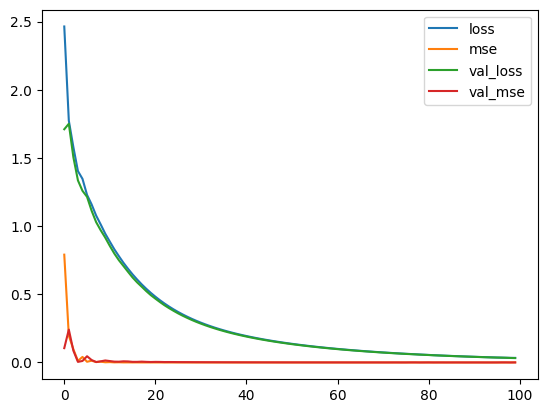

In [32]:
pd.DataFrame(history.history).plot()